TOPICOS QUE PODEM SER INTERESSANTES:
- Ver como se comportam as networks com palavras com mais que um significado.
- Existem networks, por exemplo, de cenas relacionadas com racismo? Se sim, pode ser usado para detenção. (MOTIFS)
- Falar de que temos um set de bues palavras mas um texto nao usa tantas palavras, procurar quantas palavras diferentes costuma ter um texto e criar uma random network com isso.

In [2]:
from src.random_text import get_text
import matplotlib.pyplot as plt
from textblob import TextBlob
import networkx as nx
import contractions
import numpy as np
import random


From Text to Word-adjacency networks

In [3]:
def get_network(text, disconnected_chars = ['.', ','], weighted=False):
    network = nx.DiGraph()
    words = text.split(" ")
    network.add_node(words[0])
    for (n, word) in enumerate(words[1:]):
        n+=1
        network.add_node(word)
        edge = (words[n-1], words[n])
        if edge in network.edges() and weighted:
            network.add_edge(edge[0], edge[1], weight=network.get_edge_data(*edge)['weight']+1)
        elif weighted: network.add_edge(*edge, weight=1)
        else: network.add_edge(*edge)
    
    network.remove_nodes_from(disconnected_chars)
    return network

Obtain text to analyse

In [3]:
text = get_text(size=10)

Convert from Text-To-Network

In [4]:
network = get_network(text, weighted=False)
print(network.edges())

[('salaried', 'protomagnate'), ('protomagnate', 'seismologic'), ('seismologic', 'cerecloth'), ('cerecloth', 'garget'), ('garget', 'pontify'), ('pontify', 'multipinnate'), ('multipinnate', 'propidene'), ('propidene', 'controversially'), ('controversially', 'tempse')]


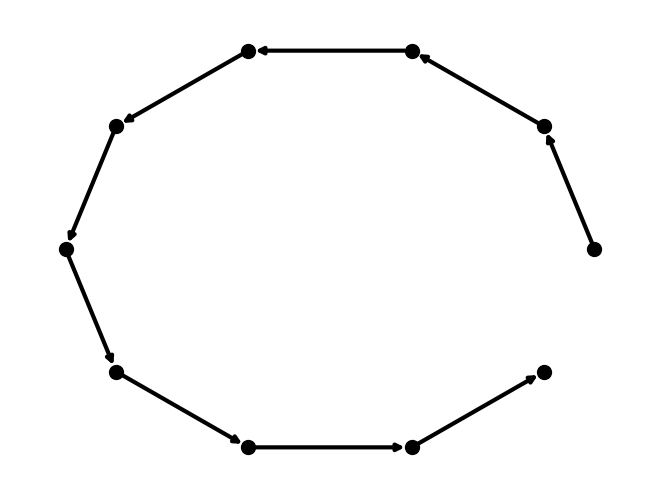

In [5]:
G = network
options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}
nx.draw_circular(G, **options)
nw = plt.show()

Network Properties:

(1) Degree Distribuition: 


É importante definir 3 situações: Um node só tem degree 1 se for um node no inicio ou no final de TODO o texto + não se repetindo. Um node tem degree 2 se for uma palavra que só se repete uma única vez no texto. Sempre que uma palavra se repete, terá sempre degree ímpar, considerando que se a palavra após for uma palavra que também estava após da mesma palavra numa recorrência anterior é considerada um novo edge.


Probabilidade de haver um node com degree n > 2, num set de K palavras:
$$P(k,n)=\frac{1}{\prod_{i=0}^{n-2}k-i}*(\frac{1}{k})^{n}$$


(2) Path Length:

(3) Clustering Coefficient:

(4) Connected Components:


## Estudo de um livro para estudo do random.

In [4]:
# Fellowship Of The Ring for random network definition purposes:

with open('The Fellowship Of The Ring.txt', 'r') as file:
    # Read the content of the file
    # Fix the contractions (ex: They're -> They are / Bilbo's -> Bilbos)
    # Make it a textblob
    text = TextBlob(contractions.fix(file.read()))

# removing (".", "_") and ' when it starts a word
for i in range(len(text.words)):
    word = text.words[i]
    word = word.replace(".", "").replace("_", "").lstrip("'")
    text.words[i] = word

# number of words
n_words = len(text.words)
print('Fellowship Of The Ring has: ' + str(n_words) + ' words.')

# number of distinct words
n_distinct_words = len(set(text.words))
print('Fellowship Of The Ring has: ' + str(n_distinct_words) + ' distinct words.')

# setting every word to lowercase
text.words = text.words.lower()

Fellowship Of The Ring has: 179543 words.
Fellowship Of The Ring has: 9815 distinct words.


In [53]:
# cleaning and checking purposes

with open('output.txt', 'w') as file:
    # Convert the WordList to a string representation and write it to the file
    file.write(str(text.words))
with open('output_set.txt', 'w') as file:
    # Convert the WordList to a string representation and write it to the file
    file.write(str(set(text.words)))

In [54]:
# getting n_distinct_"words"
number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
# getting a combination of n_words with n_distinct_words as the base set
random_text = ' '.join(random.choices(number_set, k=n_words))
# generating the network as a list of tuples
network = get_network(random_text, weighted=False)


In [8]:
# average degree
avg_degree = np.mean([d for _, d in network.degree()])

Text(0, 0.5, 'Frequency (%)')

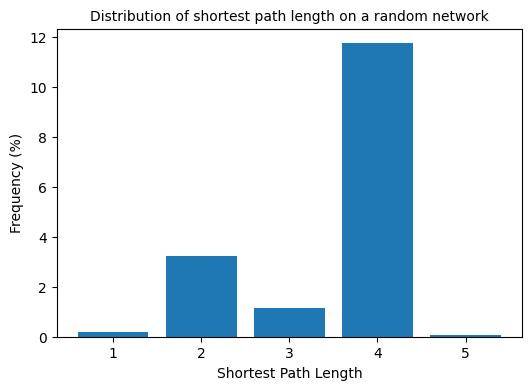

In [9]:
# Code from: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html (with a bit of tuning)

shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
# Compute the average shortest path length for each node
average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
# The average over all nodes
avg_path_lengths = np.mean(average_path_lengths)
# network diameter
diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title("Distribution of shortest path length on a random network", fontdict={"size": 10}, loc="center")
ax.set_xlabel("Shortest Path Length", fontdict={"size": 10})
ax.set_ylabel("Frequency (%)", fontdict={"size": 10})

These are the top 10 nodes with highest degree centrality:
1543 -> 0.006712071858651664
310 -> 0.006712071858651664
6202 -> 0.006514657980456026
6425 -> 0.006514657980456026
3903 -> 0.006514657980456026
5771 -> 0.006514657980456026
8684 -> 0.006415951041358207
2 -> 0.006317244102260389
5141 -> 0.006317244102260389
4722 -> 0.006317244102260389


Text(0, 0.5, 'Counts')

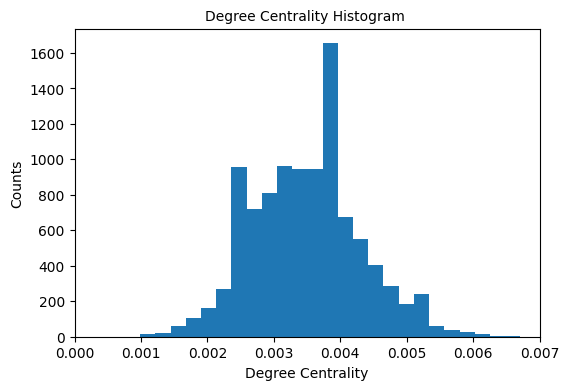

In [10]:
# degree centrality
degree_centrality = nx.centrality.degree_centrality(network)
# Compute the average degree centrality for each node
average_degree_centrality = np.mean(list(degree_centrality.values()))
# top 10 nodes by degree centrality
centrality = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
print("These are the top 10 nodes with highest degree centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in centrality]))
# highest degre centrality node
highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

These are the top 10 nodes with highest betweenness centrality:
1543 -> 0.000822247934336466
310 -> 0.0008050781292738006
5771 -> 0.0007960111706124007
6202 -> 0.0007783252986770764
3903 -> 0.0007763358111155046
6425 -> 0.0007752681804119274
8684 -> 0.0007643198861044583
2 -> 0.0007545254205102933
5141 -> 0.0007473027435360301
7158 -> 0.000740483152604607


Text(0, 0.5, 'Counts')

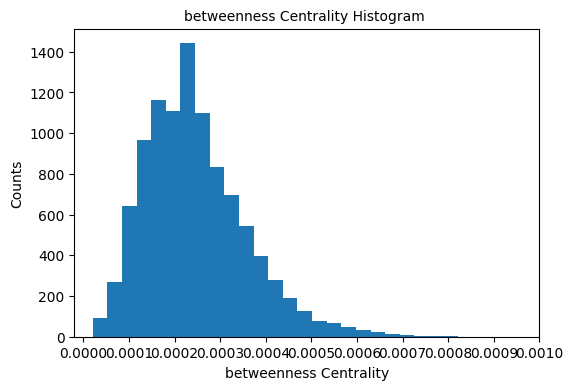

In [11]:
# betweenness centrality
betweenness_centrality = nx.centrality.betweenness_centrality(network)
# top 10 nodes by betweenness centrality
centrality = (sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
print("These are the top 10 nodes with highest betweenness centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in centrality]))
# highest degre centrality node
highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(betweenness_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001])  # set the x axis ticks
plt.title("betweenness Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("betweenness Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

In [12]:
import matplotlib.pyplot as plt

def random_analysis(n):
    avg_list = []
    avg_degree_centrality_list = []

    # Create a new figure for avg_list
    fig_avg, ax_avg = plt.subplots()

    # Create a new figure for avg_degree_centrality_list
    fig_degree, ax_degree = plt.subplots()

    for i in range(n):
        number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
        random_text = ' '.join(random.choices(number_set, k=n_words))
        network = get_network(random_text, weighted=False)

        avg_degree = np.mean([d for _, d in network.degree()])

        degree_centrality = nx.centrality.degree_centrality(network)
        average_degree_centrality = np.mean(list(degree_centrality.values()))

        avg_list.append(avg_degree)
        avg_degree_centrality_list.append(average_degree_centrality)

    # Plot avg_list in fig_avg
    ax_avg.boxplot(avg_list)
    ax_avg.set_ylabel('Value')
    ax_avg.set_title('Boxplot - avg_degree')

    # Plot avg_degree_centrality_list in fig_degree
    ax_degree.boxplot(avg_degree_centrality_list)
    ax_degree.set_ylabel('Value')
    ax_degree.set_title('Boxplot - avg_degree_centrality')

    # Display the plots
    plt.show()


In [15]:
import matplotlib.pyplot as plt

def random_analysis(n):
    avg_list = []
    avg_path_lengths_list = []
    diameter_list = []
    avg_degree_centrality_list = []

    # Create a new figure for avg_list
    fig_avg, ax_avg = plt.subplots()

    # Create a new figure for avg_degree_centrality_list
    fig_degree, ax_degree = plt.subplots()

    # Create a new figure for avg_path_lengths_list
    fig_path_length, ax_path_length = plt.subplots()

    # Create a new figure for diameter_list
    fig_diameter, ax_diameter = plt.subplots()

    for i in range(n):
        # generate a random network for the current step
        number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
        random_text = ' '.join(random.choices(number_set, k=n_words))
        network = get_network(random_text, weighted=False)
        # calculate the average degree
        avg_degree = np.mean([d for _, d in network.degree()])
        # calculate the average shortest path
        shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
        average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
        avg_path_lengths = np.mean(average_path_lengths)
        # calculate the diameter
        diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
        # calculate average degree centrality
        degree_centrality = nx.centrality.degree_centrality(network)
        average_degree_centrality = np.mean(list(degree_centrality.values()))
        # add the values to their lists
        avg_list.append(avg_degree)
        avg_path_lengths_list.append(avg_path_lengths)
        diameter_list.append(diameter)
        avg_degree_centrality_list.append(average_degree_centrality)

    # Set y-axis label
    ax_avg.set_ylabel('Value')
    ax_degree.set_ylabel('Value')
    ax_path_length.set_ylabel('Value')
    ax_diameter.set_ylabel('Value')

    # Set plot title
    ax_avg.set_title('avg_degree')
    ax_degree.set_title('avg_degree_centrality')
    ax_path_length.set_title('avg_path_length')
    ax_diameter.set_title('avg_diameter')

    # Plot avg_list in fig_avg
    ax_avg.boxplot(avg_list)

    # Plot avg_degree_centrality_list in fig_degree
    ax_degree.boxplot(avg_degree_centrality_list)

    # Plot avg_path_lengths_list in fig_path_length
    ax_path_length.boxplot(avg_path_lengths_list)

    # Plot diameter_list in fig_diameter
    ax_diameter.boxplot(diameter_list)

    # Display the plots
    plt.show()


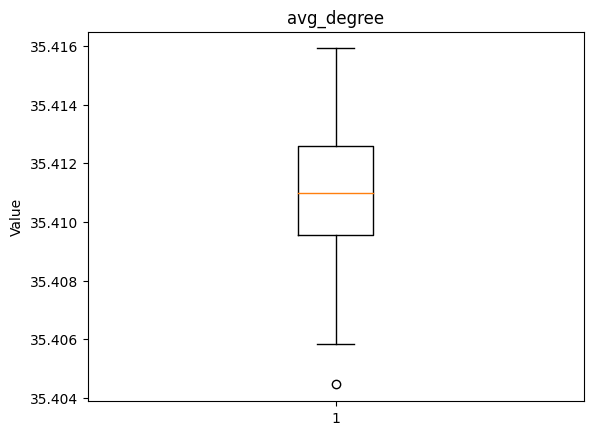

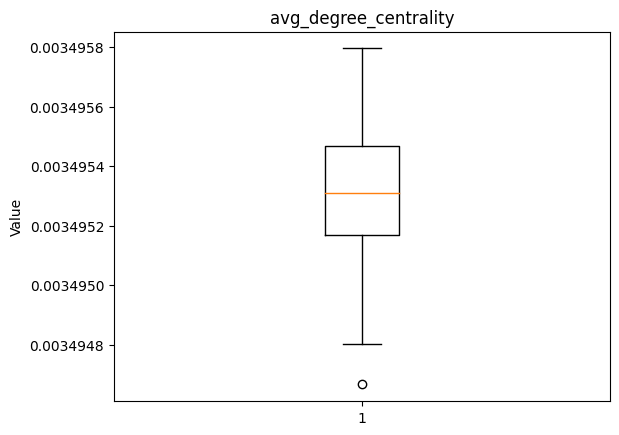

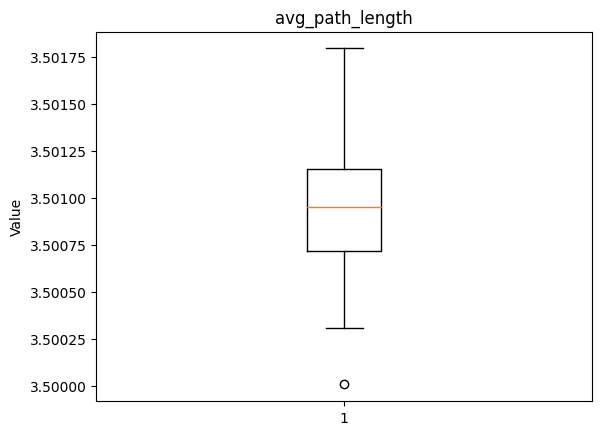

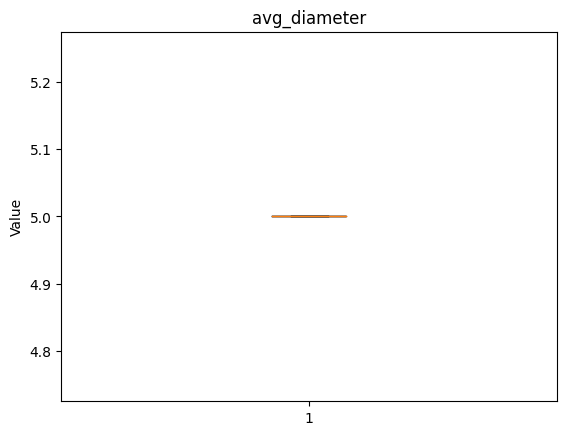

In [18]:
random_analysis(100)

## Book Analysis

Ignoring paragraphs, periods and chapters.

In [5]:
# Uniting all the words that were extracted creating what we called a "giga_phrase", a phrase that represents the entire book without paragraphs, periods or chapters
giga_phrase = ' '.join(text.words)
network = get_network(giga_phrase, weighted=False)

In [63]:
# avg_degree
avg_degree = np.mean([d for _, d in network.degree()])
avg_degree

17.412604851507595

Which is already very different from the random text, while it was ~35 we can see that it lowered to ~17.4

Average path length is: 3.1612857964525842
Diameter is: 27


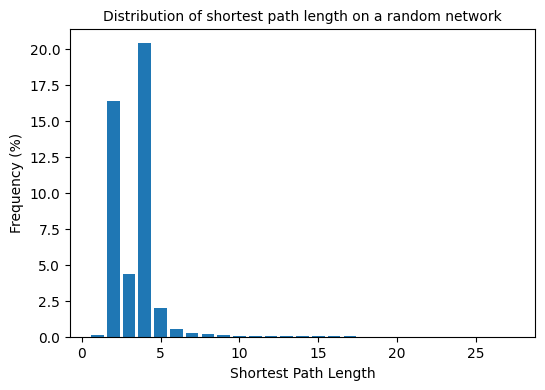

In [65]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
# Compute the average shortest path length for each node
average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
# The average over all nodes
avg_path_lengths = np.mean(average_path_lengths)
# network diameter
diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values())
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)
# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts
# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()
# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title("Distribution of shortest path length on a random network", fontdict={"size": 10}, loc="center")
ax.set_xlabel("Shortest Path Length", fontdict={"size": 10})
ax.set_ylabel("Frequency (%)", fontdict={"size": 10})
print('Average path length is: ' + str(avg_path_lengths))
print('Diameter is: ' + str(diameter))

We can see that the Diameter is way bigger, however, it looks like we can consider it as an outlier because the average path is lower! Looks like the network is even more connected!

These are the top 10 nodes with highest degree centrality:
and -> 0.5120734610588369
the -> 0.42058723500736883
of -> 0.28035370139439975
a -> 0.2098401541775309
to -> 0.19374220609908174
in -> 0.18183879378755244
he -> 0.16052601745833806
that -> 0.15361070173449723
it -> 0.14998299512526925
was -> 0.1462419226845029
These are the 10 nodes with lowest degree centrality:
overtook -> 0.00022673166307674868
badly -> 0.00022673166307674868
screwed -> 0.00022673166307674868
brushing -> 0.00022673166307674868
stock-still -> 0.00022673166307674868
flounder -> 0.00022673166307674868
water-rat -> 0.00022673166307674868
nuisances -> 0.00022673166307674868
emptied -> 0.00022673166307674868
shouldering -> 0.00022673166307674868
The average degree centrality is: 0.00197399442824029


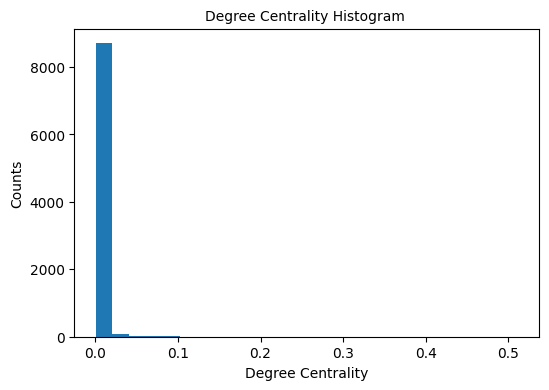

In [69]:
# degree centrality
degree_centrality = nx.centrality.degree_centrality(network)
# Compute the average degree centrality for each node
average_degree_centrality = np.mean(list(degree_centrality.values()))
# top 10 nodes by degree centrality
centrality = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
top_10_centrality = centrality[:10]
last_10_centrality = centrality[-10:]
print("These are the top 10 nodes with highest degree centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in top_10_centrality]))
print("These are the 10 nodes with lowest degree centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in last_10_centrality]))
# highest degre centrality node
# highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(degree_centrality.values(), bins=25)
# plt.xticks(ticks=[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})
print('The average degree centrality is: ' + str(average_degree_centrality))

These are the top 10 nodes with highest betweenness centrality:
and -> 0.2373053639528676
the -> 0.19323769613535074
of -> 0.11039639086170566
a -> 0.0795212714309509
to -> 0.05223933744265723
in -> 0.0460297821877604
he -> 0.041351539400188174
it -> 0.03648727430864906
that -> 0.03468297125039529
was -> 0.034662867868526424
These are the 10 nodes with lowest betweenness centrality:
schooling -> 0.0
speak-we -> 0.0
have-since -> 0.0
screws -> 0.0
aloof -> 0.0
arrange-here -> 0.0
badly -> 0.0
screwed -> 0.0
emptied -> 0.0
shouldering -> 0.0


Text(0, 0.5, 'Counts')

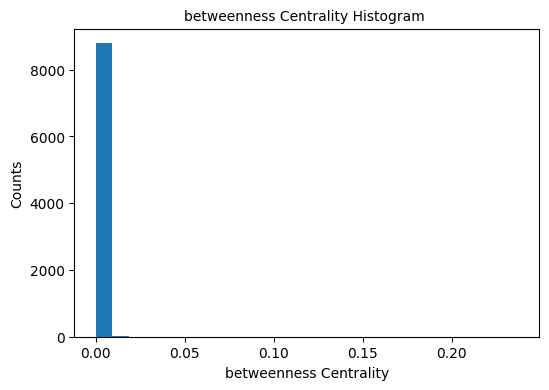

In [73]:
# betweenness centrality
betweenness_centrality = nx.centrality.betweenness_centrality(network)
# top 10 nodes by betweenness centrality
betweeness = (sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))
top_10_betweeness = betweeness[:10]
last_10_betweeness = betweeness[-10:]
print("These are the top 10 nodes with highest betweenness centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in top_10_betweeness]))
print("These are the 10 nodes with lowest betweenness centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in last_10_betweeness]))
# highest degre centrality node
# highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(betweenness_centrality.values(), bins=25)
# plt.xticks(ticks=[0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001])  # set the x axis ticks
plt.title("betweenness Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("betweenness Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

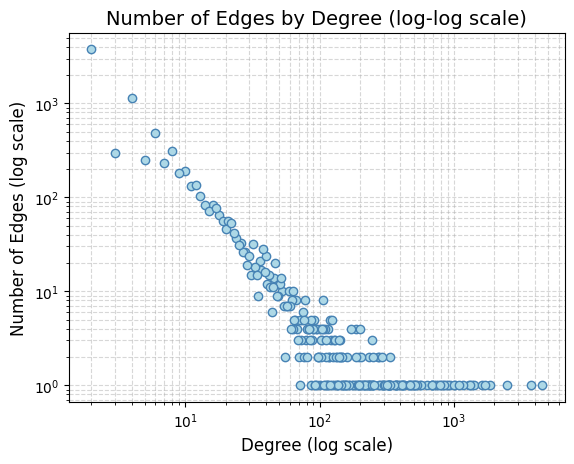

In [20]:
degrees_dict = dict(network.degree)

# Count the frequencies of each degree
degree_frequencies = {}
for degree in degrees_dict.values():
    degree_frequencies[degree] = degree_frequencies.get(degree, 0) + 1

# Extract the degrees and frequencies as separate lists
x = list(degree_frequencies.keys())
y = list(degree_frequencies.values())

# Plot the graph with log-log scale
plt.loglog(x, y, 'o', color='steelblue', markersize=6, markerfacecolor='lightblue', markeredgecolor='steelblue')
plt.xlabel('Degree (log scale)', fontsize=12)
plt.ylabel('Number of Edges (log scale)', fontsize=12)
plt.title('Number of Edges by Degree (log-log scale)', fontsize=14)

# Customize the grid lines
plt.grid(True, which="both", linestyle='--', alpha=0.5)

# Adjust the tick size and label size
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.show()